In [1]:
# Practical Deep Learning for Genomic Prediction
## A Keras based guide to implement deep learning

### M Perez-Enciso & ML Zingaretti
### miguel.perez@uab.es, laura.zingaretti@cragenomica.es

### If you find this resource useful, please cite: 
### Perez-Enciso M, Zingaretti ML, 2019. 
### A Guide on Deep Learning for Genomic Prediction. 
### Submitted

### install dependencies if needed (only once)
### Warning!!! This is the version for talos 0.6.3
###  


In [1]:
# main modules needed
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# keras items 
from keras import regularizers
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Flatten, Conv1D, MaxPooling1D, LSTM #CNNs
from keras.activations import relu, elu, linear, softmax
from keras.callbacks import EarlyStopping, Callback
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import adam, Nadam, sgd
from keras.losses import mean_squared_error, categorical_crossentropy, logcosh
from keras.utils.np_utils import to_categorical

# talos items (for hyperparameter search)
import talos as ta
import wrangle as wr
from talos.model import lr_normalizer, early_stopper
from talos.utils import hidden_layers

Using TensorFlow backend.


(479, 1279) (479,)
(120, 1279) (120,)
       min max mean sd
Train: -2.41866172921982 2.59396290204909 0.0035229899045819135 1.0008351216016704
Test: -2.22424623595239 3.27892080508434 -0.01406260136912258 1.0007208094563


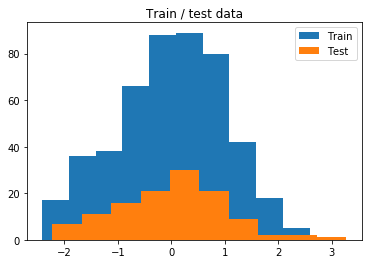

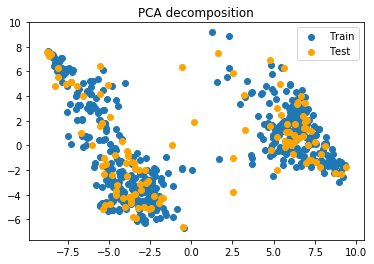

In [2]:
# DATA LOADING AND BASIC INSPECTION
# We use wheat data from BGLR (https://cran.r-project.org/web/packages/BGLR/BGLR.pdf)
'''
Matrix Y contains the average grain yield, column 1: Grain yield for environment 1 and so on.
Matrix X contains marker genotypes.
'''

# load the dataset as a pandas data frame
X = pd.read_csv('DATA/wheat.X', header=None, sep='\s+')
Y = pd.read_csv('DATA/wheat.Y', header=None, sep='\s+')

# data partitioning into train and validation
itrait=0 # first trait analyzed
X_train, X_test, y_train, y_test = train_test_split(X, Y[itrait], test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# print basic statistics: max, min, mean, sd
print('       min max mean sd')
print('Train:', y_train.min(), y_train.max(), y_train.mean(), np.sqrt(y_train.var()))
print('Test:', y_test.min(), y_test.max(), y_test.mean(), np.sqrt(y_test.var()))

# do basic histograms
plt.title('Train / test data')
plt.hist(y_train, label='Train')
plt.hist(y_test, label='Test')
plt.legend(loc='best')
plt.show()

# marker PCA, use whole X with diff color for train and test
X = np.concatenate((X_train, X_test))
pca = PCA(n_components=2)
p = pca.fit(X).fit_transform(X)
Ntrain=X_train.shape[0]
plt.title('PCA decomposition')
plt.scatter(p[0:Ntrain,0], p[0:Ntrain,1], label='Train')
plt.scatter(p[Ntrain:,0], p[Ntrain:,1], label='Test', color='orange')
plt.legend(loc='best')
plt.show()


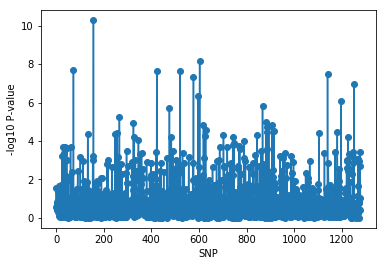

In [3]:
# OPTIONAL: SNP preselection according to a simple GWAS
pvals = []
for i in range(X_train.shape[1]):
    b, intercept, r_value, p_value, std_err = stats.linregress(X_train[i], y_train)
    pvals.append(-np.log10(p_value))
pvals = np.array(pvals)

# plot GWAS
plt.ylabel('-log10 P-value')
plt.xlabel('SNP')
plt.plot(pvals, marker='o')
plt.show()

# select N_best most associated SNPs
#N_best = X_train.shape[1] #all SNPs
N_best = 100
snp_list = pvals.argsort()[-N_best:]

# or select by min_P_value
min_P_value = 2 # P = 0.01
snp_list = np.nonzero(pvals>min_P_value)

# finally slice X
X_train = X_train[X_train.columns[snp_list]] 
X_test = X_test[X_test.columns[snp_list]] 



MSE in prediction = Tensor("Mean:0", shape=(), dtype=float64)

Corr obs vs pred = 0.36859378337152526


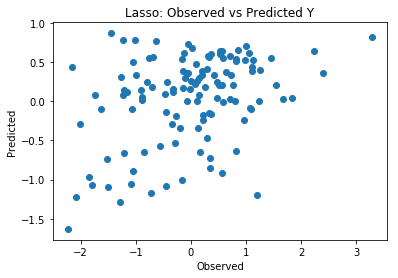

In [4]:
# Standard penalized methods (lasso using scikit-learn)

# alpha is the regularization parameter
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# mean squared error
mse = mean_squared_error(y_test, y_hat)
print('\nMSE in prediction =',mse)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat)[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('Lasso: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

# Exercises
# - Implement an internal crossvalidation to optimize alpha
# - try different sizes of most associated SNPs
# - implement ridge regression instead of lasso

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                11136     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,249
Trainable params: 13,249
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
479/47

479/479 [==============================] - 0s 115us/step - loss: 0.3803
Epoch 80/100
479/479 [==============================] - 0s 116us/step - loss: 0.3800
Epoch 81/100
479/479 [==============================] - 0s 116us/step - loss: 0.4361
Epoch 82/100
479/479 [==============================] - 0s 116us/step - loss: 0.3142
Epoch 83/100
479/479 [==============================] - 0s 117us/step - loss: 0.4091
Epoch 84/100
479/479 [==============================] - 0s 117us/step - loss: 0.3262
Epoch 85/100
479/479 [==============================] - 0s 115us/step - loss: 0.2947
Epoch 86/100
479/479 [==============================] - 0s 114us/step - loss: 0.3562
Epoch 87/100
479/479 [==============================] - 0s 113us/step - loss: 0.3503
Epoch 88/100
479/479 [==============================] - 0s 112us/step - loss: 0.2902
Epoch 89/100
479/479 [==============================] - 0s 113us/step - loss: 0.3552
Epoch 90/100
479/479 [==============================] - 0s 113us/step - loss: 

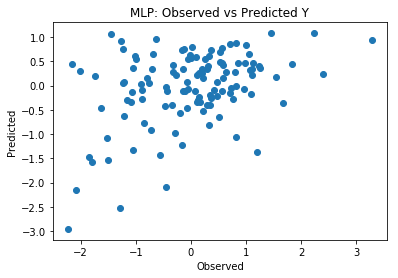

In [5]:
# Implements a standard fully connected network (MLP) for a quantitative target

# no. of SNPs in data
nSNP=X_train.shape[1] 

# Instantiate
model = Sequential()

# Add first layer
model.add(Dense(64, input_dim=nSNP))
model.add(Activation('relu'))
# Add second layer
model.add(Dense(32))
model.add(Activation('softplus'))
# Last, output layer
model.add(Dense(1))

# Model Compiling (https://keras.io/models/sequential/) 
# compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
# Stochastic Gradient Descent (‘sgd’) as optimization algorithm
# Mean Squared Error as loss, ie, quantitative variable, regression
model.compile(loss='mean_squared_error', optimizer='sgd')

# list some properties
model.summary()

# training
# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
model.fit(X_train, y_train, epochs=100)

# cross-validation: get predicted target values
y_hat = model.predict(X_test, batch_size=128)

mse_prediction = model.evaluate(X_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

# Exercises
# - Check predictions across environments (Y[0] is first environment, etc)
# - Try to improve model with other activation functions and|or no. of neurons∫ 

In [6]:
# Controlling overfit: regularization, dropout and early stopping

# deletes current model
del model

model = Sequential()

# Add l1 & l2 regularization in first layer
model.add(Dense(64, input_dim=nSNP,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
# Add second layer
model.add(Dense(32))
model.add(Activation('softplus'))
## Adding dropout to second layer
model.add(Dropout(0.2))
# Last, output layer
model.add(Dense(1))

# Model Compiling (https://keras.io/models/sequential/) 
model.compile(loss='mean_squared_error', optimizer='sgd')

# Split the train set into proper train & validation
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=0.1)
nEpochs=100

# Early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)
model.fit(X_train0, y_train0, epochs=nEpochs, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopper])

# cross-validation
mse_prediction = model.evaluate(X_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

## In this case neither l1 nor l2 regularization helps

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 431 samples, validate on 48 samples
Epoch 1/100
431/431 [==============================] - 0s 641us/step - loss: 11.0735 - val_loss: 8.1335
Epoch 2/100
431/431 [==============================] - 0s 136us/step - loss: 8.8888 - val_loss: 7.6685
Epoch 3/100
431/431 [==============================] - 0s 153us/step - loss: 8.3311 - val_loss: 7.3006
Epoch 4/100
431/431 [==============================] - 0s 156us/step - loss: 7.7928 - val_loss: 6.9755
Epoch 5/100
431/431 [==============================] - 0s 157us/step - loss: 7.4445 - val_loss: 6.6852
Epoch 6/100
431/431 [==============================] - 0s 162us/step - loss: 7.1215 - val_loss: 6.4828
Epoch 7/100
431/431 [==============================] - 0s 154us/step - loss: 6.8060 - val_loss: 6.2487
Epoch 8/100
431/431 [==============================] - 0s 156us/step - loss: 6.5735 - val_loss: 6.0574
Epoch 9/100
431

431/431 [==============================] - 0s 160us/step - loss: 3.1797 - val_loss: 2.5231
Epoch 77/100
431/431 [==============================] - 0s 160us/step - loss: 3.2379 - val_loss: 2.5636
Epoch 78/100
431/431 [==============================] - 0s 162us/step - loss: 3.0843 - val_loss: 2.8673
Epoch 79/100
431/431 [==============================] - 0s 155us/step - loss: 3.2910 - val_loss: 2.7848
Epoch 80/100
431/431 [==============================] - 0s 155us/step - loss: 3.0765 - val_loss: 2.4974
Epoch 81/100
431/431 [==============================] - 0s 158us/step - loss: 3.1720 - val_loss: 2.4704
Epoch 82/100
431/431 [==============================] - 0s 165us/step - loss: 3.0708 - val_loss: 2.4581
Epoch 83/100
431/431 [==============================] - 0s 163us/step - loss: 3.2271 - val_loss: 2.4939
Epoch 84/100
431/431 [==============================] - 0s 156us/step - loss: 3.2576 - val_loss: 2.4177
Epoch 85/100
431/431 [==============================] - 0s 156us/step - loss:

Talos is a powerful tool to keras hyperparameter optimization and model evaluation. For regression models, it includes root_mean_squared_error as an evaluation metric, but you can also use a custom function as the train/test correlation. 
**Warning**: you should include the string 'acc' in the name in order to  pick epochs will be well recorded.

In [7]:
# Defining pearson correlation as custom metric to model optimization in talos! 
# warning! you have to use acc in the metric name!

from keras import backend as K

def acc_pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)    
    

In [8]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: Simple example
# https://autonomio.github.io/docs_talos/
# 1. Hyperparameter ranges and Model definition

# model definition
def baby_model(x, y, x_val, y_val, params):    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x.shape[1],
                activation=params['activation']))
    #last neuron
    model.add(Dense(1, activation=None))
    model.compile(loss=mean_squared_error, optimizer='sgd', metrics=[acc_pearson_r])
    
    # make sure history object is returned by model.fit()
    out = model.fit(x, y,
                    epochs=50,
                    validation_data=[x_val, y_val],
                    batch_size=params['batch_size'],
                    verbose=0)
    
    # modify the output model
    return out, model

# dictionary with hyperparameters and range values allowed
p = {
    'first_neuron': [12, 48],
    'activation': [relu, elu],
    'batch_size': [10, 30]
}


In [9]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: Simple example
# 2. Search, run this grid should take between 1-2 minutes

# Split the train set into proper train & validation
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_train0=np.asarray(X_train0)
X_val=np.asarray(X_val)
y_train0=np.asarray(y_train0)
y_val=np.asarray(y_val)

# COOL! this shows real time plots
t_Init = ta.Scan(x=X_train0,
                 y=y_train0,
                 x_val=X_val,
                 y_val=y_val,
                 model=baby_model, 
                 params=p, 
                 experiment_name="Baby",
                 print_params=True)

  0%|          | 0/8 [00:00<?, ?it/s]

{'activation': <function relu at 0x7fb79005fa60>, 'batch_size': 10, 'first_neuron': 12}


 12%|█▎        | 1/8 [00:08<00:58,  8.36s/it]

{'activation': <function relu at 0x7fb79005fa60>, 'batch_size': 10, 'first_neuron': 48}


 25%|██▌       | 2/8 [00:16<00:50,  8.35s/it]

{'activation': <function relu at 0x7fb79005fa60>, 'batch_size': 30, 'first_neuron': 12}


 38%|███▊      | 3/8 [00:19<00:34,  6.80s/it]

{'activation': <function relu at 0x7fb79005fa60>, 'batch_size': 30, 'first_neuron': 48}


 50%|█████     | 4/8 [00:23<00:22,  5.71s/it]

{'activation': <function elu at 0x7fb79005f730>, 'batch_size': 10, 'first_neuron': 12}


 62%|██████▎   | 5/8 [00:31<00:19,  6.54s/it]

{'activation': <function elu at 0x7fb79005f730>, 'batch_size': 10, 'first_neuron': 48}


 75%|███████▌  | 6/8 [00:39<00:13,  6.98s/it]

{'activation': <function elu at 0x7fb79005f730>, 'batch_size': 30, 'first_neuron': 12}


 88%|████████▊ | 7/8 [00:42<00:05,  5.84s/it]

{'activation': <function elu at 0x7fb79005f730>, 'batch_size': 30, 'first_neuron': 48}


100%|██████████| 8/8 [00:45<00:00,  5.03s/it]


   round_epochs  val_loss  val_acc_pearson_r      loss  acc_pearson_r  \
0            50  0.809556           0.479088  0.316570            NaN   
1            50  0.974029           0.290083  0.206135            NaN   
2            50  0.818821           0.516016  0.425335       0.762408   
3            50  0.755092           0.566010  0.306461       0.856790   
4            50  0.898624           0.402562  0.381604            NaN   
5            50  1.003472           0.481772  0.400567            NaN   
6            50  0.883474           0.430548  0.526288       0.699488   
7            50  0.956687           0.459817  0.501658       0.721474   

                          activation  batch_size  first_neuron  
0  <function relu at 0x7fb79005fa60>          10            12  
1  <function relu at 0x7fb79005fa60>          10            48  
2  <function relu at 0x7fb79005fa60>          30            12  
3  <function relu at 0x7fb79005fa60>          30            48  
4   <function elu

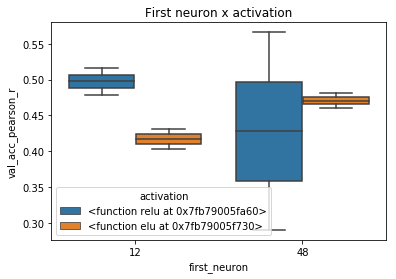

In [10]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: Simple example
# 3. Inspect results
Data=pd.DataFrame(t_Init.data)
Data["loss"] = pd.to_numeric(Data["loss"])
Data["val_acc_pearson_r"] = pd.to_numeric(Data["val_acc_pearson_r"])
print(Data)

# Minimum loss set
i=Data['val_acc_pearson_r'].argmax()
print('\nBest prediction combination:')
print(Data[i:(i+1)],'\n')

# Visualize some parameters combinations 
x = sns.boxplot(y="val_acc_pearson_r",x="first_neuron",hue="activation",data=Data).set_title('First neuron x activation')

Hyperparameter tunning: 'the real world model'. Talos uses a dictionary for keras hyperparameter optimization. You ha ve to declare the hyperparameters and their boundaries in a python dictionary. 
Warning! Keras optimizer, losses, activation, initializer need to be loaded! 
Note that talos Scan includes an argument called grid_downsampling, which allows a random search. Just to illustrate how to use talos, we've chosen 0.01 

In [12]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: more complex example
# We do a random search here (by downsampling among all possible grid values)

# model definition
def grown_model(x, y, x_val, y_val, params):
    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.add(Dropout(params['dropout']))
    
    # if we want to also test for number of layers and shapes, that's possible
    hidden_layers(model, params, 1)

    # then we finish again with completely standard Keras way
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))
    
    model.compile(loss=params['losses'],
        optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
            metrics=[acc_pearson_r])
                  
   
    out = model.fit(x, y, validation_data=[x_val, y_val], verbose=0,batch_size=params['batch_size'],
                        epochs=params['epochs'])

    # finally we have to make sure that history object and model are returned
    return out, model

# hyperparameters
p = {'first_neuron':[32,64],
     'lr':[0.2,0.5],
     'batch_size': [30,50],
     'hidden_layers':[1,2,3,4],
     'epochs': [100],
     'dropout': [0, 0.01, 0.1, 0.5],
     'optimizer': [adam,sgd,Nadam],
     'losses': [mean_squared_error],
     'activation':[relu, elu,linear],
     'last_activation': [None],
       'shapes': ['brick'],   
     'kernel_initializer':["uniform","normal"]}

# Split the train set into proper train & validation
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_train0=np.asarray(X_train0)
X_val=np.asarray(X_val)
y_train0=np.asarray(y_train0)
y_val=np.asarray(y_val)

# Example with multiclass target
# grid_downsample number of combinations to be checked 10% in this example
tcomp = ta.Scan(x=X_train0,
                y=y_train0,
                x_val=X_val,
                y_val=y_val,
                model=grown_model, 
                params=p, 
              
                experiment_name='exte_model',
               fraction_limit=0.01)



100%|██████████| 23/23 [03:45<00:00,  9.79s/it]

In [13]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: more complex example
# Some plotting
Data=pd.DataFrame(tcomp.data)
Data["val_loss"] = pd.to_numeric(Data["val_loss"])
Data["acc_pearson_r"] = pd.to_numeric(Data["acc_pearson_r"])
Data["val_acc_pearson_r"] = pd.to_numeric(Data["val_acc_pearson_r"])
#print Data
#print(Data)
#write Data
Data.to_csv("mlp_real_world.csv",index=False)



Best loss combination:
   round_epochs  val_loss  val_acc_pearson_r      loss  acc_pearson_r  \
4           100  0.577515           0.547202  0.626803       0.616183   

                         activation  batch_size  dropout  epochs  \
4  <function elu at 0x7fb79005f730>          50      0.5     100   

   first_neuron  hidden_layers kernel_initializer last_activation  \
4            32              3             normal            None   

                                            losses   lr  \
4  <function mean_squared_error at 0x7fb790032620>  0.2   

                         optimizer shapes  
4  <class 'keras.optimizers.Adam'>  brick   



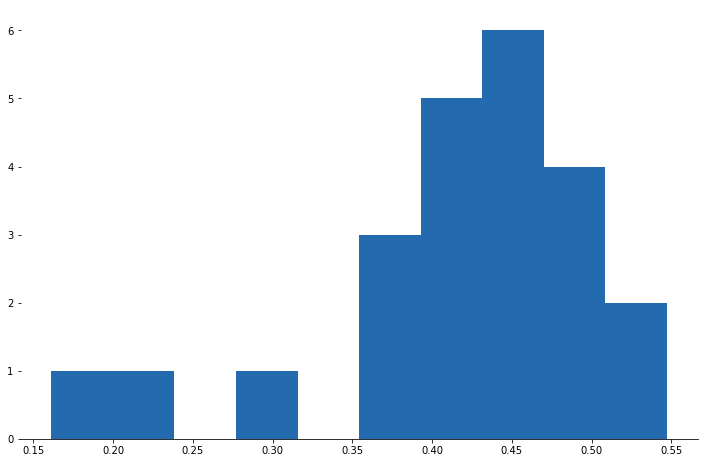

In [14]:
# Maximum correlation
i=Data['val_acc_pearson_r'].argmax()
print('\nBest loss combination:')
print(Data[i:(i+1)],'\n')
# talos have a function called reporting, which has implemented some plots 
# reporting to see the best model, draw an histogram
r = ta.Reporting('mlp_real_world.csv')
r.plot_hist('val_acc_pearson_r')

0.5472017526626587


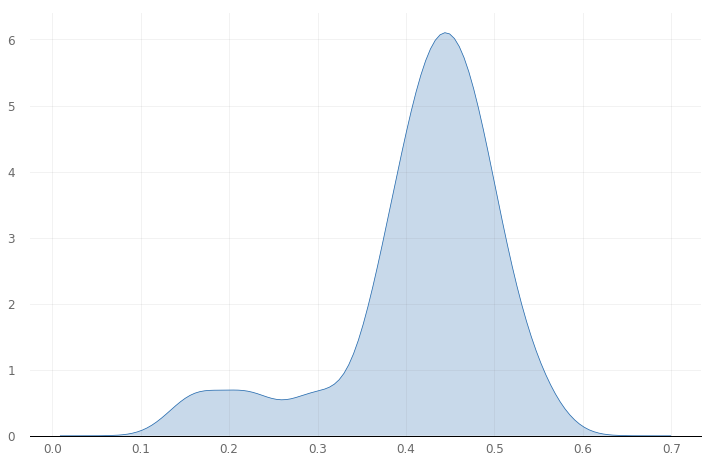

In [17]:
print(r.high('val_acc_pearson_r'))
# we can see the distribution of the val_acc parameter chosen 
r.plot_kde('val_acc_pearson_r')


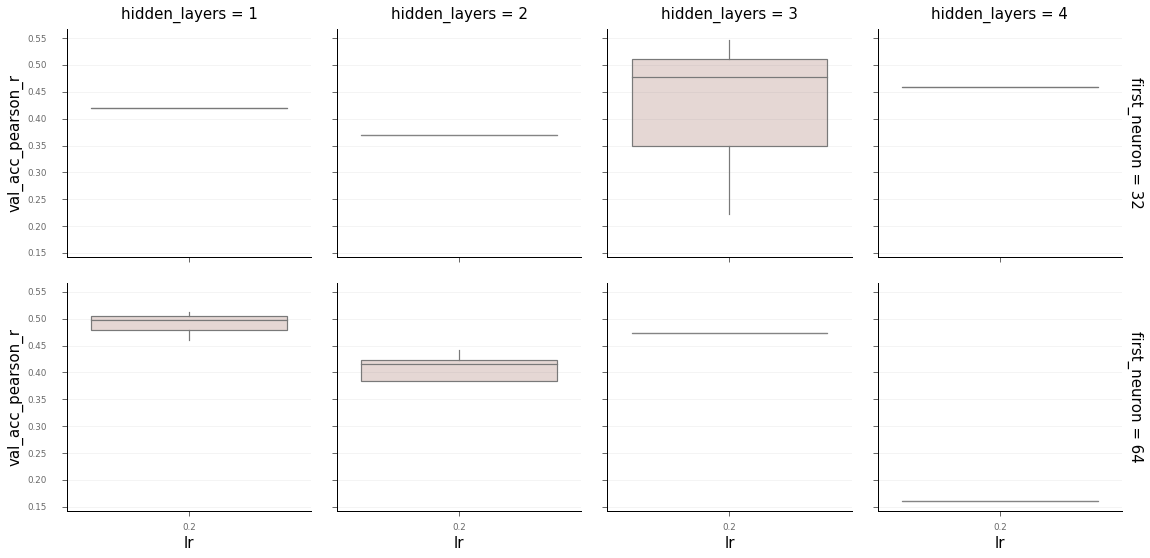

In [18]:
import seaborn as sns
# You also can use seaborn to check other combination of parameters
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})   
g = sns.FacetGrid(tcomp.data, col="hidden_layers",row="first_neuron", margin_titles=True,height=4)
g.map(sns.boxplot,"lr","val_acc_pearson_r", palette=sns.cubehelix_palette(8),saturation=.5);

Finally, use Deploy() to save and transfer the results of your "star" model 

In [38]:
from talos import Deploy

Deploy(tcomp, 'the_real_word_experiment',metric='val_acc_pearson_r',asc=False)


Deploy package the_real_word_experiment have been saved.


N / class
Test  [91, 321, 67]
Train  [30, 83, 6]
All  [121, 404, 73]
120/120 [==============================] - 0s 523us/step

MSE in prediction = 1.8882378339767456

Probabilities matrix
 [[2.69096762e-01 6.29787683e-01 1.01074547e-01 4.10420907e-05]
 [8.95286202e-02 8.15132022e-01 9.53183770e-02 2.10014132e-05]
 [2.16145217e-01 6.68324649e-01 1.15473352e-01 5.67840725e-05]
 [4.67411563e-04 2.20375791e-01 7.79125273e-01 3.15680081e-05]]


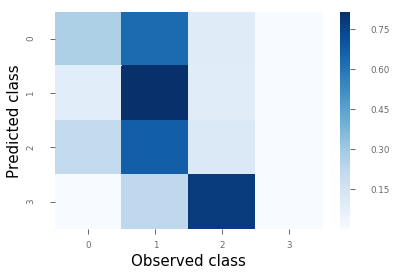

In [39]:
# MLP example with multiclass target

# Let us round class vector and make a few classes, all positive numbers
# just a trick to convert to classes
yi_train=[int(round(x-np.min(y_train))/2) for x in y_train]
yi_test=[int(round(x-np.min(y_test))/2) for x in y_test]

# N obs / clas; this may result in some very rare classes so consider merging
print('N / class')
print('Test ',[yi_train.count(i) for i in range(max(yi_train+yi_test))])
print('Train ',[yi_test.count(i) for i in range(max(yi_train+yi_test))])
print('All ',[(yi_test+yi_train).count(i) for i in range(max(yi_train+yi_test))])
# WARNING: make sure all clases in test are in train!!

# convert to classes, i need to make all classes equivalent
n_train=len(yi_train)
itemp = to_categorical(yi_train+yi_test)
i_train = itemp[:n_train,:]
i_test = itemp[n_train:,:]

# no. of SNPs in data
nSNP=X_train.shape[1]
nClasses=i_train.shape[1]

# Instantiate
model = Sequential()

# Add first layer
model.add(Dense(64, input_dim=nSNP))
model.add(Activation('relu'))
# Add second layer
model.add(Dense(32))
model.add(Activation('softplus'))
# Last, output layer
model.add(Dense(nClasses, activation='softmax'))

# Model Compiling 
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training
model.fit(X_train, i_train, epochs=100, verbose=0)

# cross-validation: get predicted target values
i_hat = model.predict(X_test, batch_size=128)

mse_prediction = model.evaluate(X_test, i_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# do a heatplot, obs vs expected class distribution
# collect all results by class
# compute average prediction by class
heat = np.zeros([nClasses,nClasses])
for i in range(nClasses):
    iclass = np.nonzero(i_test[:,i]>0) # samples of i-th class
    for j in range(nClasses):
        heat[i,j] = np.mean(i_hat[iclass,j])

# plot observed vs. predicted targets
print('\nProbabilities matrix\n',heat)
plot = sns.heatmap(heat, cmap="Blues")
plot.set(xlabel='Observed class', ylabel='Predicted class')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 57, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 28, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                57408     
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
__________

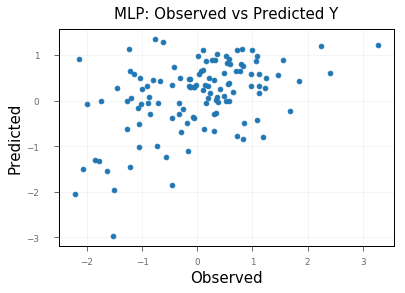

In [40]:
#--> CNN example

nSNP=X_train.shape[1] 
nStride=3  # stride between convolutions
nFilter=32 # no. of convolutions

# Instantiate
model_cnn = Sequential()

#WARNING!!! I need this to match dimensions 
#https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
X2_train = np.expand_dims(X_train, axis=2) 
X2_test = np.expand_dims(X_test, axis=2) 

# add convolutional layer
model_cnn.add(Conv1D(nFilter, kernel_size=3, strides=nStride, input_shape=(nSNP,1)))
# add pooling layer: takes maximum of two consecutive values
model_cnn.add(MaxPooling1D(pool_size=2))
# Solutions above are linearized to accommodate a standard layer
model_cnn.add(Flatten())
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(32))
model_cnn.add(Activation('softplus'))
model_cnn.add(Dense(1))

# Model Compiling (https://keras.io/models/sequential/) 
model_cnn.compile(loss='mean_squared_error', optimizer='sgd')

# list some properties
model_cnn.summary()

# training
model_cnn.fit(X2_train, y_train, epochs=200, verbose=0)

# cross-validation
mse_prediction = model_cnn.evaluate(X2_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# get predicted target values
y_hat = model_cnn.predict(X2_test, batch_size=128)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

In [41]:
print(X_train.shape)

(479, 173)


In [ ]:
#--> RNN example

nSNP=X_train.shape[1] 

#-->data shape
X2_train = np.expand_dims(X_train, axis=2) 
X2_test = np.expand_dims(X_test, axis=2) 

# Instantiate
model_cnn = Sequential()

# Instantiate
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(None,1), activation="tanh"))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True, activation="tanh"))
model.add(Dropout(0.1))
model.add(LSTM(64, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.add(Activation("tanh"))
model.compile(optimizer="adam",loss=mean_squared_error, metrics=['mae'])
model.summary()

model.fit(X2_train, y_train, epochs=200, verbose=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
__________

In [ ]:
# cross-validation
mse_prediction = model.evaluate(X2_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# get predicted target values
y_hat = model.predict(X2_test, batch_size=128)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

In [ ]:
# save and reuse model
from keras.models import load_model

# creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')  

# deletes the existing model
del model

# loads a compiled model, identical to the previous one
model = load_model('my_model.h5')